<center><h1><b><u> Multilayer Perceptron for MNIST Dataset From Scratch</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [70]:
import numpy as np
from operator import itemgetter
import random
import json
import math
import pickle
import matplotlib.pyplot as plt
from PIL import Image

## __Loading the Data__

In [71]:
def extract_images(filename):
    '''Many file formats use magic numbers so that file readers can easily identify them to verify its reading correct file type. This prevents some errors. Each
    pixel is represented from value 0-255 (an unsigned byte/8 bit integer). Metadata is big endian (>, normal) and 4 byte/32 bit integer and stored as 1D array.
    file.read(x) takes x bytes from the file and creates an immutable buffer (a bytes object, an array of bytes) and stores it in memory. frombuffer interprets buffer object as array
    of bytes of certain data type. It doesn't copy the data just provides a view of the existing data and converts to numpy array.'''
    with open(filename, 'rb') as f: #read binary
        buffer = f.read(16) #metadata
        magic, num_images, rows, cols = np.frombuffer(buffer, dtype='>i4') #rows and columns per image (dimensions)
        data = np.frombuffer(f.read(), dtype=np.uint8) #read and store remaining data in 1D numpy array; #numpy spaces out elements instead of commas
        data = data.reshape(num_images, rows, cols).astype(np.float32) #reshape flat data into 3D, num_image amt of rows x cols arrays
    return data

def extract_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = np.frombuffer(f.read(8), dtype='>i4')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels] #certain row of the identity matrix

def load_mnist():
    data_path = '../data/MNIST/raw'
    train_images = extract_images(f'{data_path}/train-images-idx3-ubyte')
    train_labels = extract_labels(f'{data_path}/train-labels-idx1-ubyte')
    test_images = extract_images(f'{data_path}/t10k-images-idx3-ubyte')
    test_labels = extract_labels(f'{data_path}/t10k-labels-idx1-ubyte')

    #Make sure data is right shape for forward pass
    train_images_flat = train_images.reshape(60000, 784).T
    test_images_flat = test_images.reshape(10000, 784).T

    train_labels_one_hot = one_hot_encode(train_labels).T
    test_labels_one_hot = one_hot_encode(test_labels).T
    
    return (train_images_flat, train_labels_one_hot), (test_images_flat, test_labels_one_hot) #each dataset is tuple of numpy arrays

In [72]:
#Comma means tuple containing 1 element otherwise would just be int; numpy arrays come with useful attributes like shape
(train_x, train_y), (test_x, test_y) = load_mnist()

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (784, 60000)
train_y shape: (10, 60000)
test_x shape: (784, 10000)
test_y shape: (10, 10000)


### __Splitting the Data__

In [73]:
len_train = train_x.shape[1]

split_index = int(len_train * 0.8)  #index separating train and val

# Split the array
sub_train_x = train_x[:, :split_index]
sub_train_y = train_y[:, :split_index]

val_x = train_x[:, split_index:]
val_y = train_y[:, split_index:]

print("sub_train_x shape:", sub_train_x.shape)
print("sub_train_y shape:", sub_train_y.shape)
print("val_x shape:", val_x.shape)
print("val_y shape:", val_y.shape)

sub_train_x shape: (784, 48000)
sub_train_y shape: (10, 48000)
val_x shape: (784, 12000)
val_y shape: (10, 12000)


### __Viewing a Sample__

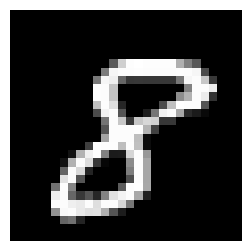

In [74]:
index = random.randrange(0, train_x.shape[1])

plt.figure(figsize=(6, 3))
plt.imshow(train_x[:, index].reshape(28,28), cmap = 'gray')
plt.axis("off")
plt.show()

## __Initializing the Hyperparameters__

In [169]:
class Hypers:
    def __init__(self, hyperpath):
        with open(hyperpath, 'r') as file:
            hyper_dict = json.load(file)
            
        self.lr = hyper_dict['learning_rate']
        self.b_size = hyper_dict['b_size']
        self.epochs = hyper_dict['epochs']
        self.hidden = hyper_dict['hidden']


#can feed this into functions that need hypers
hypers = Hypers('../config/mlp-scratch-hyperparameters.json')

In [76]:
def create_mini_batches(X, Y, hypers): #batch -> [mini_batches]
    mini_batches = []
    n_samples = X.shape[1]
    #Randomize order of samples in each epoch to prevent bias (not necesssary for full batch GD)
    indices = np.random.permutation(n_samples)


    num_batches = math.ceil(n_samples / hypers.b_size)  # Rounding up to account for possible last batch < m
    
    #For each mini batch
    for i in range(num_batches):
        #Calculate indices of columns to take subset (can't be greater than n_samples)
        batch_start = i * hypers.b_size
        batch_end = (i + 1) * hypers.b_size

        safe_batch_end = min(batch_end, n_samples)  # Ensure we don't go past n_samples; accounts for last batch
        batch_indices = indices[batch_start:safe_batch_end]
        
        #Take subsets to get a mini batch
        X_mini = X[:, batch_indices]
        Y_mini = Y[:, batch_indices]

        #Append the mini batch
        mini_batches.append((X_mini, Y_mini))
    
    return mini_batches

## __Defining Functions__

### __Activations__

In [77]:
def softmax(x): #x is vector
    # Subtract max for numerical stability, keeping dims for proper broadcasting; axis = 0 is all elements you can reach by varying first index (row), which is a column
    x_shifted = x - np.max(x, axis=0, keepdims=True)
    
    # Compute exponentials
    exp_x = np.exp(x_shifted)
    
    # Compute softmax
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

In [78]:
def relu(z):
    return np.maximum(z, 0)

In [79]:
def drelu_dz(z):
    return np.where(z <= 0, 0.0, 1.0).astype(np.float32)

### __Parameter Initialization__

In [80]:
def he_init(shape):
    #output, input
    fan_out, fan_in = shape
    
    #scaling factor; 2 for ReLU
    scaling = np.sqrt(2/fan_in)

    #create matrix sampled from Gaussian and multiply by scaling factor
    return np.random.randn(fan_out, fan_in) * scaling

## __Model Structure__

### __Average Loss Function for Categorical Cross-Entropy__

In [81]:
class AvgCategoricalCrossEntropy:
    #loss function
    def __call__(self, A2, Y):
        m = Y.shape[1]
        
        epsilon=1e-15
        A2_safe = np.maximum(A2, epsilon)

        #same as doing (1/m) * sum of all columns (sum of values in a column of Y * np.log(A2_safe)); (1/m) total loss across whole batch
        return (-1/m) * np.sum(Y * np.log(A2_safe)) 
    

    def backward(self, X, Y, parameters, layer_computations):
        W1, b1, W2, b2 = parameters
        Z1, A1, Z2, A2 = layer_computations

        m = X.shape[1] #batch size

        dZ2 = (A2 - Y)
        dW2 = (1/m)*(dZ2 @ A1.T)
        db2 = (1/m)*np.sum(dZ2, axis = 1, keepdims = True) #sums across each row for all rows (summing the columns)

        dZ1 = (W2.T @ dZ2)*drelu_dz(Z1) 
        dW1 = (1/m)*(dZ1 @ X.T)
        db1 = (1/m)*np.sum(dZ1, axis = 1, keepdims = True)


        #{'dW1': dW1, 'db1': db1, 'dW2' : dW2, 'db2': db2}
        return dW1, db1, dW2, db2

### __Optimizer__

In [82]:
class StochasticGD:
    def __init__(self, lr = 0.01):
        self.lr = lr

    def step(self, parameters, partials):
        #Unpack info
        W1, b1, W2, b2 = parameters
        dW1, db1, dW2, db2 = partials
        
        #Take step and update parameters in model object
        W1 = W1 - self.lr*dW1
        b1 = b1 - self.lr*db1
        W2 = W2 - self.lr*dW2
        b2 = b2 - self.lr*db2

        return W1, b1, W2, b2

### __The MLP__

In [83]:
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        #Input to hidden
        self.W1 = he_init((hidden_dim, input_dim)) 
        self.b1 = he_init((hidden_dim, 1))

        #hidden to output
        self.W2 = he_init((output_dim, hidden_dim))
        self.b2 = he_init((output_dim, 1))
        
        self.parameters = self.W1, self.b1, self.W2, self.b2
    
    def update_parameters(self, updated_params):
            self.parameters = updated_params
            self.W1, self.b1, self.W2, self.b2 = updated_params #makes sure the parameter attributes update for their use in __call__
        
    #forward
    def __call__(self, X, view_prob = False):
        #input to hidden
        Z1 = self.W1 @ X + self.b1 
        A1 = relu(Z1)

        #Hidden to output
        Z2 = self.W2 @ A1 + self.b2

        #Calculate loss
        A2 = softmax(Z2)

        return Z1, A1, Z2, A2

## __Training__

In [84]:
def evaluate(model, X, Y):    
    layer_computations = model(X)
    A2 = layer_computations[3]

    #Find max along column for prediction
    y_pred = np.argmax(A2, axis = 0) 
    y_truth = np.argmax(Y, axis = 0)
    
    acc = np.sum(y_pred == y_truth) / len(y_truth) #same as np.mean
    return acc

In [85]:
#One epoch of training
def train_one_epoch(model, X, Y, criterion, optimizer, hypers, val_x = None, val_y = None):
    mini_batches = create_mini_batches(X, Y, hypers)
    total_loss = 0

    for X_mini, Y_mini in mini_batches:
        #Forward pass
        layer_computations = model(X_mini) #A2 column consists of probabilities of each class
        A2 = layer_computations[3]

        #Loss calculation (not necessary for backprop/training)
        avg_loss = criterion(A2, Y_mini) #avg loss across all samples in mini batch
        total_loss += avg_loss

        #Backprop
        partials = criterion.backward(X_mini, Y_mini, model.parameters, layer_computations)

        #Gd
        updated_params = optimizer.step(model.parameters, partials)
        model.update_parameters(updated_params)
    
    avg_mini_batch_loss = total_loss/len(mini_batches)
     
    if val_x is not None and val_y is not None:
        train_acc = evaluate(model, X, Y)
        val_acc = evaluate(model, val_x, val_y)
        return avg_mini_batch_loss, train_acc, val_acc
    else:
        return avg_mini_batch_loss

In [89]:
def train_n_epochs(model, train_x, train_y, categorical_cross, optimizer, val_x, val_y, hypers):
    avg_losses = []
    val_accs = []
    train_accs = []

    for epoch in range(hypers.epochs):
        #avg_loss = avg loss across all mini batches in epoch = avg epoch loss
        avg_loss, train_acc, val_acc = train_one_epoch(model, train_x, train_y, categorical_cross, optimizer, hypers, val_x, val_y)
        avg_losses.append(avg_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)

        if ((epoch + 1) % 10 == 0 or epoch == hypers.epochs - 1):
            print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%')
        
    return avg_losses, val_accs, train_accs

### __Training with Train/Validation Subsets__

In [90]:
input_dim = train_x.shape[0]
output_dim = train_y.shape[0]

model = MLP(input_dim, hypers.hidden, output_dim)
categorical_cross = AvgCategoricalCrossEntropy()
optimizer = StochasticGD(hypers.lr)

In [91]:
avg_losses, val_accs, train_accs = train_n_epochs(model, sub_train_x, sub_train_y, categorical_cross, optimizer, val_x, val_y, hypers)

Epoch 10, Loss: 0.0836, Train Accuracy: 97.81%, Val Accuracy: 93.96%
Epoch 20, Loss: 0.0303, Train Accuracy: 99.23%, Val Accuracy: 94.95%
Epoch 30, Loss: 0.0141, Train Accuracy: 99.73%, Val Accuracy: 95.38%
Epoch 40, Loss: 0.0076, Train Accuracy: 99.87%, Val Accuracy: 95.38%
Epoch 50, Loss: 0.0046, Train Accuracy: 99.94%, Val Accuracy: 95.47%
Epoch 60, Loss: 0.0030, Train Accuracy: 99.97%, Val Accuracy: 95.52%
Epoch 70, Loss: 0.0022, Train Accuracy: 99.99%, Val Accuracy: 95.56%
Epoch 80, Loss: 0.0017, Train Accuracy: 99.99%, Val Accuracy: 95.59%
Epoch 90, Loss: 0.0014, Train Accuracy: 99.99%, Val Accuracy: 95.63%
Epoch 100, Loss: 0.0011, Train Accuracy: 99.99%, Val Accuracy: 95.62%
Epoch 110, Loss: 0.0010, Train Accuracy: 99.99%, Val Accuracy: 95.70%
Epoch 120, Loss: 0.0008, Train Accuracy: 99.99%, Val Accuracy: 95.66%


### __Visual of Loss and Validation Accuracy Per Epoch__

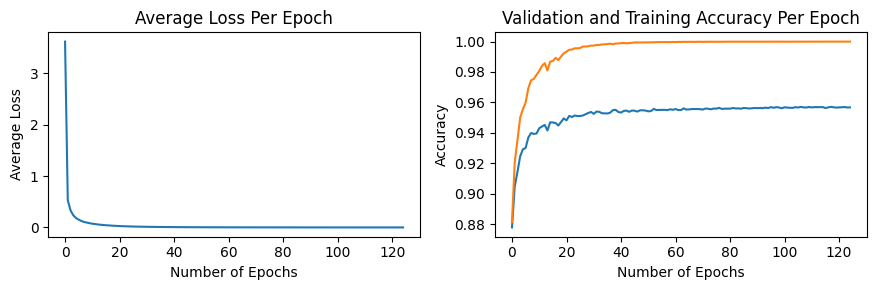

In [93]:
all_epochs = np.arange(0, hypers.epochs)

#1 row 2 columns, each ax object creates a plot (Axes object is not axis but a subplot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3)) 

#Avg loss
ax1.plot(all_epochs, avg_losses)
ax1.set_title("Average Loss Per Epoch")
ax1.set_xlabel("Number of Epochs")
ax1.set_ylabel("Average Loss")

#Val/Train accuracy
ax2.plot(all_epochs, val_accs)
ax2.plot(all_epochs, train_accs)
ax2.set_title("Validation and Training Accuracy Per Epoch")
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")

plt.tight_layout() #adjusts spacing
plt.show()

### __Hyperparameter Tuning with Gridsearch__

In [94]:
#For grid search (different values printed and returned)
def train_n_epochs_grid(model, sub_train_x, sub_train_y, categorical_cross, optimizer, val_x, val_y, hypers):
    avg_losses = []
    val_accs = []
    train_accs = []

    for epoch in range(hypers.epochs):
        avg_loss, train_acc, val_acc = train_one_epoch(model, sub_train_x, sub_train_y, categorical_cross, optimizer, hypers, val_x, val_y)
        avg_losses.append(avg_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)

        if (epoch == 0 or epoch == hypers.epochs - 1):
            print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%')
        
    
    #Return final validation accuracy
    return val_acc

In [95]:
def alter_hyper(hypers, hypercombo):
    hypers.lr = hypercombo['lr']
    hypers.b_size = hypercombo['b_size']
    hypers.epochs = hypercombo['epochs']
    hypers.hidden = hypercombo['hidden']

In [96]:
#list of all possible dict combinations of hypers
def create_param_grid(hyperdict):
    '''For hyperparameter i, go through all the dictionaries currently in the parameter grid. Within each "base" dictionary of this parameter grid, add key value pair (hyper i: valj),
    incremting j until you add all values to this "base" dictionary. Append each of these dictionaries to the parameter grid. Repeat for all hyperparameters to get all possible combinatinos.
    dictionaries. Must create copy so we don't lose possible combinations. For example, if we had with two key value pairs in param_combo and we were iterating through the values of the second key 
    still, we would be within the param_combo loop still and end up just replacing the values in this dictionary (which is in param_grid). This new approach copying is essentially "resetting" 
    the dictionary to what it was before and creating len(values for hyper i) of that.'''

    param_grid = [{}]
    for hyper in hyperdict.keys():
        #do this because we will iterate over param_grid and don't want to modify while iterating over it
        new_param_grid = []

        #For each existing combination
        for param_combo in param_grid:
            for val in hyperdict[hyper]:
                #Must create copy so we don't lose possible combinations
                new_params = param_combo.copy() 
                new_params[hyper] = val #no copy means param_combo here would replace value in param grid dict
                new_param_grid.append(new_params)
        param_grid = new_param_grid
    return param_grid

In [106]:
def grid_search(hyperdict, hypers, sub_train_x, sub_train_y, categorical_cross, optimizer, val_x, val_y):
    best_hypers = None
    best_val_accuracy = 0
    orig_hypers = hypers #store original hypers to reset before end of search
    
    for hypercombo in create_param_grid(hyperdict): 
        #Use the new hyperparameter combo
        alter_hyper(hypers, hypercombo)
        print(hypercombo)

        #Reinstantiate model and optimizer
        model = MLP(input_dim, hypers.hidden, output_dim)
        optimizer = StochasticGD(hypers.lr)

        #Train the model
        val_accuracy = train_n_epochs_grid(model, sub_train_x, sub_train_y, categorical_cross, optimizer, val_x, val_y, hypers)
        print(f'\n\033[1mVal Accuracy: {val_accuracy*100:.2f}%\033[0m\n')
        
        #Update the best hyperparameters and validation accuracy
        if (val_accuracy > best_val_accuracy):
            best_val_accuracy = val_accuracy
            best_hypers = hypercombo
    
    hypers = orig_hypers
    return best_hypers, best_val_accuracy

In [107]:
hyperdict = {
    'lr': [0.01],
    'b_size': [128, 512],
    'epochs': [100, 125],
    'hidden': [1024, 2048]
}

categorical_cross = AvgCategoricalCrossEntropy()

best_hypers, best_val_accuracy = grid_search(hyperdict, hypers, sub_train_x, sub_train_y, categorical_cross, optimizer, val_x, val_y)

{'lr': 0.01, 'b_size': 128, 'epochs': 100, 'hidden': 1024}
Epoch 1, Loss: 1.79, Train Accuracy: 88.69%, Val Accuracy: 88.82%
Epoch 100, Loss: 0.00, Train Accuracy: 99.89%, Val Accuracy: 96.38%

Val Accuracy: 96.38%

{'lr': 0.01, 'b_size': 128, 'epochs': 100, 'hidden': 2048}
Epoch 1, Loss: 4.69, Train Accuracy: 84.97%, Val Accuracy: 85.52%
Epoch 100, Loss: 0.03, Train Accuracy: 99.41%, Val Accuracy: 95.74%

Val Accuracy: 95.74%

{'lr': 0.01, 'b_size': 128, 'epochs': 125, 'hidden': 1024}
Epoch 1, Loss: 1.40, Train Accuracy: 89.00%, Val Accuracy: 88.97%
Epoch 125, Loss: 0.00, Train Accuracy: 99.94%, Val Accuracy: 96.43%

Val Accuracy: 96.43%

{'lr': 0.01, 'b_size': 128, 'epochs': 125, 'hidden': 2048}
Epoch 1, Loss: 2.18, Train Accuracy: 91.05%, Val Accuracy: 90.40%
Epoch 125, Loss: 0.00, Train Accuracy: 99.97%, Val Accuracy: 96.29%

Val Accuracy: 96.29%

{'lr': 0.01, 'b_size': 512, 'epochs': 100, 'hidden': 1024}
Epoch 1, Loss: 2.91, Train Accuracy: 85.14%, Val Accuracy: 85.20%
Epoch 100, 

In [108]:
print(f'\n\033[1mBest Hyperparameters: {best_hypers}\nBest Validation Accuracy:{best_val_accuracy*100: .2f}%\033[0m')


Best Hyperparameters: {'lr': 0.01, 'b_size': 128, 'epochs': 125, 'hidden': 1024}
Best Validation Accuracy: 96.43%


### __Final Training with Full Train Dataset__

In [176]:
model = MLP(input_dim, hypers.hidden, output_dim)
optimizer = StochasticGD(hypers.lr)
categorical_cross = AvgCategoricalCrossEntropy()

In [177]:
for epoch in range(hypers.epochs):
    avg_loss = train_one_epoch(model, train_x, train_y, categorical_cross, optimizer, hypers)
    if (epoch == 0 or epoch == hypers.epochs - 1):
            print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 2.2921
Epoch 125, Loss: 0.0020


## __Evaluation__

In [178]:
train_acc = evaluate(model, train_x, train_y) 
test_acc = evaluate(model, test_x, test_y) 


print(f'Train Accuracy: {train_acc*100:.2f}%')
print(f'Test Accuracy: {test_acc*100:.2f}%')

Train Accuracy: 99.93%
Test Accuracy: 96.70%


## __Pickling the Model__

In [179]:
f_name = f"mlp-scratch-{test_acc*100:.2f}.pkl"

In [180]:
#Saving the moddel
#with open(f'../models/{f_name}', 'wb') as f:
    #pickle.dump(model, f)

In [181]:
# Loading the model
with open(f'../models/{f_name}', 'rb') as f:
    model = pickle.load(f)

## __Inference on New Image__

### __Preprocess and Visualizing Image__

In [182]:
#Normalize and change to proper dimension
def preprocess(image_path):
    #Resize and convert to numpy
    image = Image.open(image_path).convert('L')
    image = np.array(image.resize((28, 28)))
    
    im_normalized = image / 255.0
    
    return im_normalized.reshape(784, 1)

def preprocess_vis(image_path):
    image = Image.open(image_path).convert('L')
    return image.resize((28, 28))

In [223]:
image_path = '../data/test-images/1.png'

visual_im = preprocess_vis(image_path)

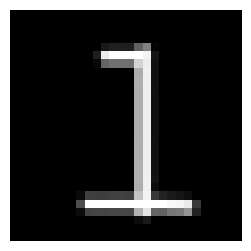

In [224]:
plt.figure(figsize=(6, 3))
plt.axis("off")

#Capture return value
_ = plt.imshow(visual_im, cmap="grey")

### __Feeding through MLP__

In [225]:
def classify_image(model, image_path):
    image = preprocess(image_path)


    layer_computations = model(image)
    A2 = layer_computations[3]

    #Extract and sort probabilities
    prob_classes = list(enumerate(A2[:, 0])) # [(0, .70), ...]
    prob_classes.sort(key = itemgetter(1), reverse = True)

    #Extract classification
    y_pred = np.argmax(A2, axis = 0)[0] #Extract only element in the 1d array

    return prob_classes, y_pred

In [226]:
'''Test images are likely out of distribution.'''
prob_classes, y_pred = classify_image(model, image_path)

for num, probability in prob_classes:
    print(f'Probability of {num}:{probability.item() * 100: .3f}%')

print(f'\nPredicted number: {y_pred}')

Probability of 1: 65.587%
Probability of 8: 29.290%
Probability of 0: 2.889%
Probability of 3: 1.938%
Probability of 4: 0.209%
Probability of 9: 0.056%
Probability of 6: 0.018%
Probability of 5: 0.010%
Probability of 7: 0.002%
Probability of 2: 0.000%

Predicted number: 1
